# Behavioral Cloning - Self-Driving Car ND Project

## Introduction

In this project, a technique called end-to-end learning will be discussed. Using a provided simulator, I'll record driving data according to my behavior behind the wheel, and then I'll train a deep network to mimic my way of driving and learn how to drive in the simulator by itself.

## Data collection

The simulator collects data from three cameras mounted on the windshield of the car (left, center and right cameras). It also records the steering angle associated with each set of images and it records approximately 10 data points (three images plus a steering angle) per second.

Training the network with only regular driving data might not be sufficient, because the network might never learn how to recover from a mistake. One way of improving this issue is to augment the data by using the left and right images and add corrective biases to their associated steering angle (this method was used is this NVIDIA paper: http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf).

Another method, which was used here, is to collect data while driving somewhat irregularly. Data was recorded with the car drinving on the edges of the track and also going in the reverse direction of the track (to balance the total number of left and right turns).

## Data visualization

In [1]:
### Import necessary packages
import numpy as np
import pandas as pd
import cv2
from os.path import basename, isfile
import pickle
import json
from sklearn.utils import shuffle
from scipy.signal import gaussian
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def smooth(curve, window_len=11, window='hanning'):

    
    #s=numpy.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w = np.ones(window_len,'d')
    elif window == 'hanning':
        w = np.hanning(window_len)
    else:
        sigma = 3.
        mu = 0.
        x = np.arange(-3*sigma, 3.1*sigma, sigma/(window_len/6.))
        #print(len(x))
        w = (np.exp((-1.*x**2)/(2*sigma**2)))*(1./(np.sqrt(2*np.pi*sigma**2))) 

    y = np.convolve(w/w.sum(), curve, mode='same')
    return y

#plt.plot(center_rev['steering'][:], 'y', 
#         smooth(center_rev['steering'][:], window='gaussian', window_len=6), 'b', 
#         smooth(center_rev['steering'][:], window='hanning', window_len=7), 'r', 
#         smooth(center_rev['steering'][:], window='flat', window_len=50), 'g')

In [3]:
def visualize_dataset(file_name):
    dataset = pd.read_csv(file_name, header=0)
    #time = np.linspace(0., dataset.shape[0]/10., num=dataset.shape[0])
    dataset['steering'] = smooth(dataset['steering'][:], window_len=20, window='gaussian')
    #plt.plot(time, dataset['steering'])
    #print(dataset.shape)
    #zero = dataset[((dataset['steering'] <= 0.05) & (dataset['steering'] >= -0.05))]
    #positive = dataset[dataset['steering'] > 0.05]
    #negative = dataset[dataset['steering'] < -0.05]
    #print(zero.shape, positive.shape, negative.shape)
    return dataset #zero.reset_index(), positive.reset_index(), negative.reset_index()

In [4]:
#u_data0, u_data = visualize_dataset('udacity_data/driving_log.csv')

In [5]:
#c_rev_zero, c_rev_p, c_rev_n = visualize_dataset('track1/full_center_rev1/driving_log.csv')
c_rev = visualize_dataset('track1/full_center_rev1/driving_log.csv')

In [6]:
#c_zero, c_p, c_n = visualize_dataset('track1/full_center1/driving_log.csv')
c = visualize_dataset('track1/full_center1/driving_log.csv')

In [7]:
#tL_rev_zero, tL_rev_p, tL_rev_n = visualize_dataset('track1/full_toLeft_rev1/driving_log.csv')
tL_rev = visualize_dataset('track1/full_toLeft_rev1/driving_log.csv')

In [8]:
#tL_zero, tL_p, tL_n = visualize_dataset('track1/full_toLeft1/driving_log.csv')
tL = visualize_dataset('track1/full_toLeft1/driving_log.csv')

In [9]:
#tR_rev_zero, tR_rev_p, tR_rev_n = visualize_dataset('track1/full_toRight_rev1/driving_log.csv')
tR_rev = visualize_dataset('track1/full_toRight_rev1/driving_log.csv')

In [10]:
#tR_zero, tR_p, tR_n = visualize_dataset('track1/full_toRight1/driving_log.csv')
tR = visualize_dataset('track1/full_toRight1/driving_log.csv')

In [11]:
#c2_zero, c2_p, c2_n = visualize_dataset('track1/full_center2/driving_log.csv')
c2 = visualize_dataset('track1/full_center2/driving_log.csv')

In [12]:
#c_rev2_zero, c_rev2_p, c_rev2_n = visualize_dataset('track1/full_center_rev2/driving_log.csv')
c_rev2 = visualize_dataset('track1/full_center_rev2/driving_log.csv')

In [13]:
#tL2_zero, tL2_p, tL2_n = visualize_dataset('track1/full_toLeft2/driving_log.csv')
tL2 = visualize_dataset('track1/full_toLeft2/driving_log.csv')

In [14]:
#tL_rev2_zero, tL_rev2_p, tL_rev2_n = visualize_dataset('track1/full_toLeft_rev2/driving_log.csv')
tL_rev2 = visualize_dataset('track1/full_toLeft_rev2/driving_log.csv')

In [15]:
#tR2_zero, tR2_p, tR2_n = visualize_dataset('track1/full_toRight2/driving_log.csv')
tR2 = visualize_dataset('track1/full_toRight2/driving_log.csv')

In [16]:
#tR_rev2_zero, tR_rev2_p, tR_rev2_n = visualize_dataset('track1/full_toRight_rev2/driving_log.csv')
tR_rev2 = visualize_dataset('track1/full_toRight_rev2/driving_log.csv')

## Data preparation

In [70]:
def read_images(dataset, bias=0):
    img_data = np.empty((dataset.shape[0], 32, 32, 3))
    for i in range(dataset.shape[0]):
        #img = cv2.imread('IMG/' + basename(dataset[i]), cv2.IMREAD_GRAYSCALE)
        img = cv2.imread('IMG/' + basename(dataset[i]))
        if bias > 0:
            x_start = 0
            x_end = 240
        elif bias < 0:
            x_start = 80
            x_end = 320
        else:
            x_start = 40
            x_end = 280
        x_start = 0
        x_end = 320
        img = cv2.resize(img[80:120, x_start:x_end, :],
                         None, fx=32./(x_end - x_start), fy=32./40.,
                         interpolation=cv2.INTER_AREA)
        img_data[i, :, :, :] = img
    return img_data

def load_dataset_from_log(driving_log_df):
    center_img, center_steering = load_col_from_log(driving_log_df, col_name='center')
    left_img, left_steering = load_col_from_log(driving_log_df, col_name='left', bias=0.15)
    right_img, right_steering = load_col_from_log(driving_log_df, col_name='right', bias=-0.15)
    img_data = np.r_[center_img, left_img, right_img]
    steering_data = np.r_[center_steering, 
                                 left_steering, 
                                 right_steering]
    print(img_data.shape, steering_data.shape)
    return img_data, steering_data

def load_col_from_log(driving_log_df, col_name, bias=0.):
    img_data = read_images(driving_log_df[col_name], bias=bias)
    steering_data = driving_log_df['steering'] + bias
    return img_data, steering_data

#def concat_data(dataset_list):
#    final_dataset = dataset_list[0]
#    for i in range(1, len(dataset_list)):
#        final_dataset = np.append(final_dataset, dataset_list[i], axis=0)
#    return final_dataset

In [71]:
#pickle_file = 'train_data.pickle'
#pickle_file = 'train_data_norm_gauss.pickle'
#pickle_file = 'train_data_norm_gauss_2.pickle'
#pickle_file = 'train_data_raw.pickle'

#if isfile(pickle_file):
#        print('File already exists.')
#        with open(pickle_file, mode='rb') as f:
#            train = pickle.load(f)
#        img_train = train['img']
#        steering_train = train['steering']
#else:
    
#gaussian_window = gaussian(50, std=5.)
#sigma = 3.
#mu = 0.
#x = np.arange(-3*sigma, 3.1*sigma, sigma/16) # Size of window: 12
#gaussian_window = (np.exp((-1.*x**2)/(2*sigma**2)))*(1./(np.sqrt(2*np.pi*sigma**2)))
#gaussian_window = 1.2*gaussian_window/np.sum(gaussian_window)

c_img, c_steering = load_dataset_from_log(c)
c_rev_img, c_rev_steering = load_dataset_from_log(c_rev)

tL_img, tL_steering = load_col_from_log(tL, col_name='center', bias=-0.25)
tL_rev_img, tL_rev_steering = load_col_from_log(tL_rev, col_name='center', bias=-0.25)

tR_img, tR_steering = load_col_from_log(tR, col_name='center', bias=0.25)
tR_rev_img, tR_rev_steering = load_col_from_log(tR_rev, col_name='center', bias=0.25)

c2_img, c2_steering = load_dataset_from_log(c2)
c_rev2_img, c_rev2_steering = load_dataset_from_log(c_rev2)

tL2_img, tL2_steering = load_col_from_log(tL2, col_name='center', bias=-0.25)
tL_rev2_img, tL_rev2_steering = load_col_from_log(tL_rev2, col_name='center', bias=-0.25)

tR2_img, tR2_steering = load_col_from_log(tR2, col_name='center', bias=0.25)
tR_rev2_img, tR_rev2_steering = load_col_from_log(tR_rev2, col_name='center', bias=0.25)

#u_img, u_steering = load_dataset_from_log(u_data)

img_train = np.r_[c_img, c_rev_img,
                         tL_img, tL_rev_img,
                         tR_img, tR_rev_img,
                         c2_img, c_rev2_img,
                         tL2_img, tL_rev2_img,
                         tR2_img, tR_rev2_img]
steering_train = np.r_[c_steering, c_rev_steering,
                             tL_steering, tL_rev_steering,
                             tR_steering, tR_rev_steering,
                             c2_steering, c_rev2_steering,
                             tL2_steering, tL_rev2_steering,
                             tR2_steering, tR_rev2_steering]

print(img_train.shape, steering_train.shape)

(6207, 32, 32, 3) (6207,)
(3729, 32, 32, 3) (3729,)
(12912, 32, 32, 3) (12912,)
(11532, 32, 32, 3) (11532,)
(52839, 32, 32, 3) (52839,)


In [72]:
#c0_img, c0_steering = load_col_from_log(center_zero, col_name='center', bias=0.)
#c_rev0_img, c_rev0_steering = load_col_from_log(center_rev_zero, col_name='center', bias=0.)

#tL0_img, tL0_steering = load_col_from_log(to_left_zero, col_name='left', bias=-0.05)
#tL_rev0_img, tL_rev0_steering = load_col_from_log(to_left_rev_zero, col_name='left', bias=-0.1)

#tR0_img, tR0_steering = load_col_from_log(to_right_zero, col_name='right', bias=0.05)
#tR_rev0_img, tR_rev0_steering = load_col_from_log(to_right_rev_zero, col_name='right', bias=0.1)

#c20_img, c20_steering = load_col_from_log(center2_zero, col_name='center', bias=0.)
#c_rev20_img, c_rev20_steering = load_col_from_log(center_rev2_zero, col_name='center', bias=0.)

#tL20_img, tL20_steering = load_col_from_log(to_left2_zero, col_name='left', bias=-0.05)
#tL_rev20_img, tL_rev20_steering = load_col_from_log(to_left_rev2_zero, col_name='left', bias=-0.1)

#tR20_img, tR20_steering = load_col_from_log(to_right2_zero, col_name='right', bias=0.05)
#tR_rev20_img, tR_rev20_steering = load_col_from_log(to_right_rev2_zero, col_name='right', bias=0.1)

#u0_img, u0_steering = load_dataset_from_log(u_data0)

#img0_train = concat_data([c0_img, #c_rev0_img,
#                         tL0_img, #tL_rev0_img,
#                         tR0_img, #tR_rev0_img,
#                         c20_img, #c_rev20_img,
#                         tL20_img, #tL_rev20_img,
#                         tR20_img])#, tR_rev20_img])
#steering0_train = concat_data([c0_steering, #c_rev0_steering, 
#                              tL0_steering, #tL_rev0_steering, 
#                              tR0_steering, #tR_rev0_steering, 
#                              c20_steering, #c_rev20_steering, 
#                              tL20_steering, #tL_rev20_steering, 
#                              tR20_steering])#, tR_rev20_steering])

#print(u0_img.shape, u0_steering.shape)

img_z = img_train[((steering_train <= 0.05) & (steering_train >= -0.05)), :, :, :]
img_p = img_train[steering_train > 0.05, :, :, :]
img_n = img_train[steering_train < -0.05, :, :, :]
str_z = steering_train[((steering_train <= 0.05) & (steering_train >= -0.05))]
str_p = steering_train[steering_train > 0.05]
str_n = steering_train[steering_train < -0.05]

print(img_z.shape, str_z.shape)
print(img_p.shape, str_p.shape)
print(img_n.shape, str_n.shape)

(8643, 32, 32, 3) (8643,)
(20931, 32, 32, 3) (20931,)
(23265, 32, 32, 3) (23265,)


In [11]:
break
if isfile(pickle_file):
        print('File already exists. Skipping pickling...')
else:
    print('Pickling...')
    try:
        f = open(pickle_file, 'wb')
        save = {
            'img': img_train,
            'steering': steering_train,
        }
        pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
        f.close()
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

Pickling...


(13716, 32, 32, 1)


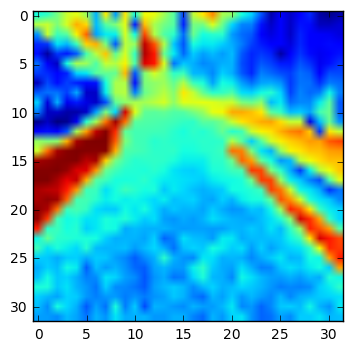

In [52]:
break
img_train_s = img_train.reshape((img_train.shape[0], 32, 32, 1))
print(img_train_s.shape)
plt.imshow(img_train_s[10, :, :, 0])

## Network architecture

In [73]:
from keras.models import Sequential
from keras.layers.core import Dense, Flatten, Activation, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

# Fix error with TF and Keras
import tensorflow as tf
tf.python.control_flow_ops = tf

model = Sequential()
model.add(Convolution2D(4, 1, 1, border_mode='valid', input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(Convolution2D(8, 5, 5, border_mode='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Convolution2D(8, 1, 1, border_mode='valid'))
model.add(Activation('relu'))
model.add(Convolution2D(16, 3, 3, border_mode='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Convolution2D(16, 1, 1, border_mode='valid'))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3, border_mode='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(1))

Using TensorFlow backend.


## Training and Validation

In [74]:
def preprocess_img(img, steering):
    flip = np.random.uniform(low=-0.5, high=0.5)
    if flip >= 0:
        img = cv2.flip(img, 1)
        steering = -steering
    img = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2HSV)
    img = img/255.
    gamma = np.random.uniform(low=0.01, high=2.0)
    img[:, :, 2] = img[:, :, 2]**gamma
    img = cv2.cvtColor((img*255.).astype(np.uint8), cv2.COLOR_HSV2RGB)
    #tx = np.random.randint(low=-8, high=9)
    #ty = np.random.randint(low=-10, high=11)
    #M = np.float32([[1,0,tx],[0,1,ty]])
    #img = cv2.warpAffine(img,M,(32,32))
    #steering = steering + tx*0.01
    img = img - img.mean()
    img = img/img.max()
    sigma = np.random.uniform(low=0.001, high=0.01)
    noise = np.random.randn(32, 32, 3)*sigma
    img = img + noise
    return img, steering

def batch_generator(img0_dataset, steering0_dataset, 
                    imgP_dataset, steeringP_dataset,
                    imgN_dataset, steeringN_dataset,
                    batch_size=1800):
    img_batch = np.empty((batch_size, 32, 32, 3))
    steering_batch = np.empty((batch_size,))
    
    while True:
        
        img0_dataset, steering0_dataset = shuffle(img0_dataset, 
                                                  steering0_dataset)
        for i in range(400):
            img_batch[i, :, :, :], steering_batch[i] = preprocess_img(img0_dataset[i, :, :, :], steering0_dataset[i])
        
        imgP_dataset, steeringP_dataset = shuffle(imgP_dataset, 
                                                  steeringP_dataset)
        for i in range(400, 1100):
            i_ = i - 400
            img_batch[i, :, :, :], steering_batch[i] = preprocess_img(imgP_dataset[i_, :, :, :], steeringP_dataset[i_])
        
        imgN_dataset, steeringN_dataset = shuffle(imgN_dataset, 
                                                  steeringN_dataset)
        for i in range(1100, batch_size):
            i_ = i - 1100
            img_batch[i, :, :, :], steering_batch[i] = preprocess_img(imgN_dataset[i_, :, :, :], steeringN_dataset[i_])
        
        yield (img_batch, steering_batch)

In [75]:
#from keras.optimizers import Adam

#adam = Adam(lr=0.001, epsilon=1e-04)
### Train model to minimize 'mse'
model.compile(loss='mean_squared_error', optimizer='adam')
#history = model.fit(img_train_s, steering_train_s, nb_epoch=5, validation_split=0.01)
datagen = batch_generator(img_z, str_z, 
                          img_p, str_p,
                          img_n, str_n)
history = model.fit_generator(datagen, 
                              samples_per_epoch=48600, nb_epoch=10, 
                              verbose=1)


### Save model parameters
model.save_weights('teste_raw6.h5')
model_json = model.to_json()
with open('teste_raw6.json', 'w') as f:
    json.dump(model_json, f)

Epoch 1/10
48600/48600 [==============================] - 128s - loss: 0.0291   
Epoch 2/10
48600/48600 [==============================] - 80s - loss: 0.0188    
Epoch 3/10
48600/48600 [==============================] - 79s - loss: 0.0164    
Epoch 4/10
48600/48600 [==============================] - 90s - loss: 0.0148    
Epoch 5/10
48600/48600 [==============================] - 98s - loss: 0.0135    
Epoch 6/10
48600/48600 [==============================] - 94s - loss: 0.0124    
Epoch 7/10
48600/48600 [==============================] - 89s - loss: 0.0117    
Epoch 8/10
48600/48600 [==============================] - 87s - loss: 0.0113    
Epoch 9/10
48600/48600 [==============================] - 86s - loss: 0.0109    
Epoch 10/10
48600/48600 [==============================] - 89s - loss: 0.0105    


In [20]:
import json
with open('teste_norm.json', 'w') as f:
    json.dump(model_json, f)

## Testing on unseen data

In [4]:
from keras.models import model_from_json
import json
# Fix error with TF and Keras
import tensorflow as tf
tf.python.control_flow_ops = tf

with open('teste_norm.json', 'r') as jfile:
        model = model_from_json(json.loads(jfile.read()))

model.compile("adam", "mse")
weights_file = 'teste_norm.h5'
model.load_weights(weights_file)

Using TensorFlow backend.


## Draft code blocks

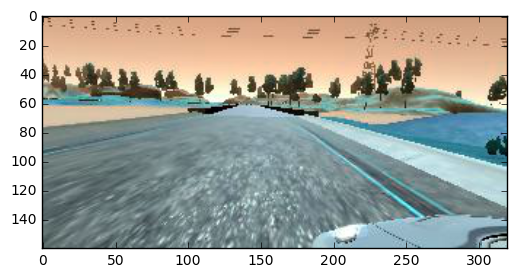

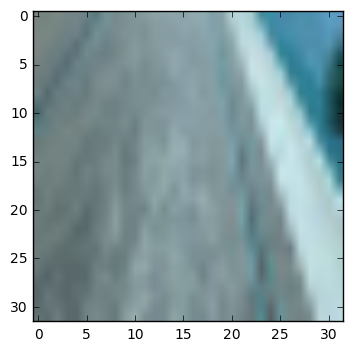

In [78]:
img = cv2.imread('IMG/' + basename(tL['left'][645]))
x_start = 0
x_end = 320
plt.imshow(img)
plt.figure()
img = cv2.resize(img[80:120, x_start:x_end, :],
                 None, fx=32./(x_end - x_start), fy=32./40.,
                 interpolation=cv2.INTER_AREA)
plt.imshow(img)

-0.0319089685793


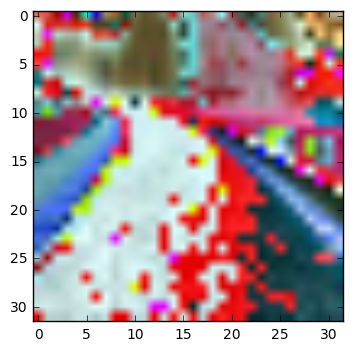

In [30]:
#plt.imshow((img_train[95,:,:,:]))
#print(steering_train[95])
#plt.hist(steering_train, bins=101)
img = img_z[10001,:,:,:]
img = img - img.mean()
plt.imshow(img/img.max())
print(str_z[10001])
#print(((img - img.mean())/((img - img.mean()).max())).mean())

0.0447977135041 -0.0447977135041
8.25241283043e-05


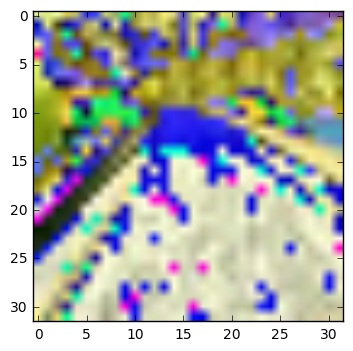

In [48]:
#print(img_train.shape)
img, s = preprocess_img(img_z[10001, :, :, :], str_z[10001])
#img = cv2.imread('IMG/' + basename(center['center'][0]))
#print(img.dtype)
#print(img_train[2000, :, :, 2].astype(int))
#print(img_train[2000, :, :, 2])
print(s, str_z[10001])
plt.imshow(img)
print(img.mean())

(array([ 7240.,     0.,     0.,     0.,     0.,  8486.,     0.,     0.,
            0.,  6425.]),
 array([-0.25, -0.2 , -0.15, -0.1 , -0.05,  0.  ,  0.05,  0.1 ,  0.15,
         0.2 ,  0.25]),
 <a list of 10 Patch objects>)

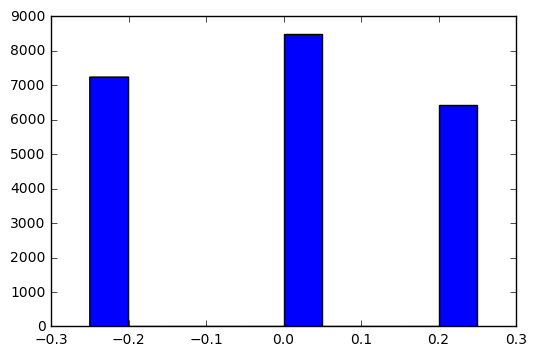

In [19]:
plt.hist(steering0_train)

(array([    6.,     7.,   101.,   394.,  1406.,  1405.,   304.,    44.,
            6.,     2.]),
 array([-0.9426954 , -0.74842586, -0.55415632, -0.35988678, -0.16561724,
         0.0286523 ,  0.22292184,  0.41719138,  0.61146092,  0.80573046,  1.        ]),
 <a list of 10 Patch objects>)

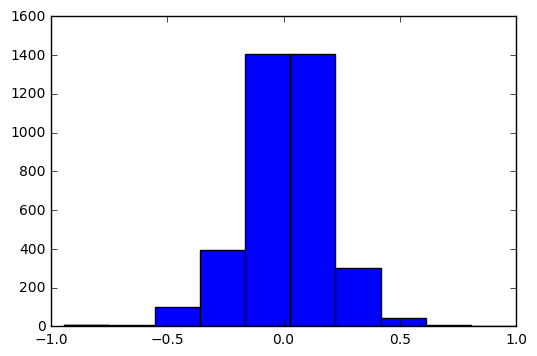

In [16]:
plt.hist(u_data['steering'], bins=10)

(array([   20.,   193.,  1144.,  2849.,  3320.,  2711.,  2274.,   980.,
          199.,    26.]),
 array([-1.25, -1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,
         1.  ,  1.25]),
 <a list of 10 Patch objects>)

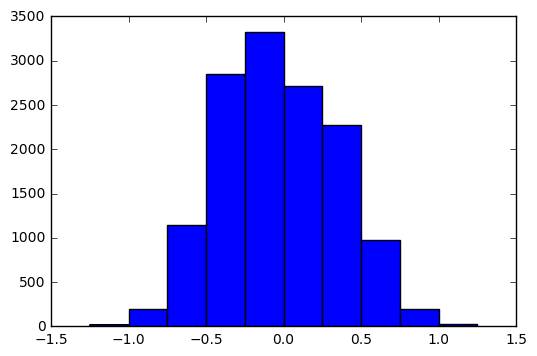

In [24]:
plt.hist(steering_train, bins=10)

In [17]:
print(center.head(3))

                                              center  \
2  C:\Users\Lucas\Documents\udacity\sdcnd\IMG\cen...   
3  C:\Users\Lucas\Documents\udacity\sdcnd\IMG\cen...   
4  C:\Users\Lucas\Documents\udacity\sdcnd\IMG\cen...   

                                                left  \
2   C:\Users\Lucas\Documents\udacity\sdcnd\IMG\le...   
3   C:\Users\Lucas\Documents\udacity\sdcnd\IMG\le...   
4   C:\Users\Lucas\Documents\udacity\sdcnd\IMG\le...   

                                               right  steering  throttle  \
2   C:\Users\Lucas\Documents\udacity\sdcnd\IMG\ri... -0.019536       0.0   
3   C:\Users\Lucas\Documents\udacity\sdcnd\IMG\ri... -0.319081       0.0   
4   C:\Users\Lucas\Documents\udacity\sdcnd\IMG\ri... -0.408188       0.0   

   break     speed  
2      0  11.00692  
3      0  10.86299  
4      0  10.66938  


1.1949076502920148
(32, 32)
0.04356943


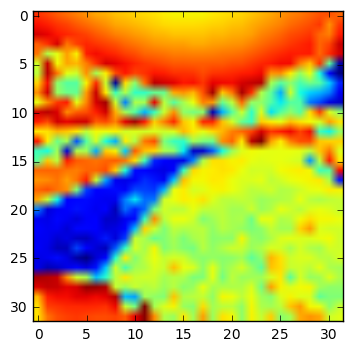

In [87]:
img = cv2.imread('IMG/' + basename(to_right2['right'][763]))
img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
gamma = .3+1.5*np.random.uniform()
print(gamma)
img[:, :, 2] = img[:, :, 2]*gamma
img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img = cv2.resize(img[:, :], None, fx=32./320, fy=32./160, interpolation=cv2.INTER_AREA)
#img = cv2.resize(img[50:135, (50 - 50):(270 + 50), :], (32, 32), interpolation=cv2.INTER_AREA)
#img = img.reshape((32, 32, 3))
img = img/255. - 0.5
print(img.shape)
print(to_right2['steering'][763])
plt.imshow(img[:,:])

In [23]:
a = 1
print(steering_train[(10:12) + a])

SyntaxError: invalid syntax (<ipython-input-23-4d722000dcd9>, line 2)

In [15]:
img_ = img_train[2501, :, :, :]
t_img_ = img_[None, :, :, :]
print(float(model.predict(t_img_, batch_size=1)), steering_train[2501])

0.19697950780391693 0.1


In [22]:
print(c_steering.shape)
print(c_rev_steering.shape)

(6207,)
(3729,)


-0.000588181761673


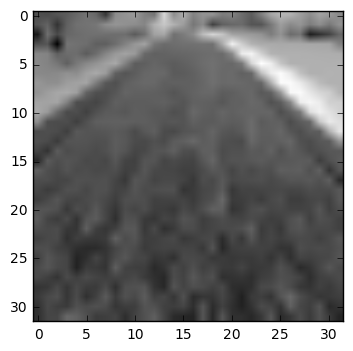

In [12]:
img_ = img_train[6287, :, :, :]
plt.imshow(img_[:, :, 0], cmap='gray')
print(steering_train[6287])

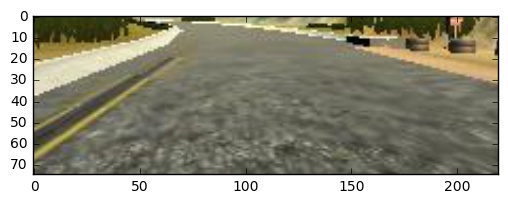

In [72]:
img = cv2.imread('IMG/' + basename(to_right['right'][0]))
from PIL import Image
img_pil = Image.open('IMG/' + basename(to_right['right'][100]))
img_pil = np.asarray(img_pil)
plt.imshow(img_pil[60:135, 50:270, :])

(160, 320, 1)


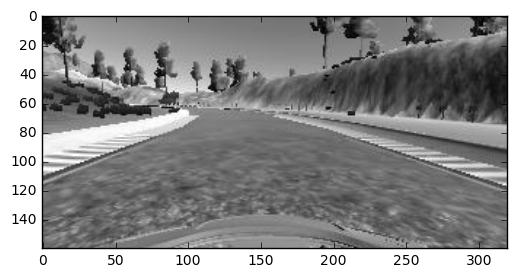

In [36]:
img = cv2.imread('IMG/' + basename(center['center'][0]), cv2.IMREAD_GRAYSCALE)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = img.reshape((160, 320, 1))
print(img.shape)
plt.imshow(img[:, :, 0], cmap='gray')

(32, 32, 1)


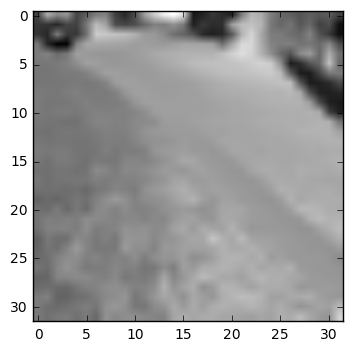

In [13]:
img = cv2.imread('IMG/' + basename(center['right'][1010]))
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#img = cv2.Canny(img, 90, 95)
img = cv2.resize(img[60:135, 100:320], None, fx=32./220., fy=32./75., interpolation=cv2.INTER_AREA)
#img = cv2.resize(img[60:135, 50:270], (32,32), interpolation=cv2.INTER_AREA)
img = img.reshape((32, 32, 1))
img = img/255. - 0.5
print(img.shape)
plt.imshow(img[:,:,0], cmap='gray')

In [39]:
img = img[None, :, :, :]
img = img/255. - 0.5
print(img.shape)
print(float(model.predict(img)))

(1, 32, 32, 3)
-0.02849855273962021


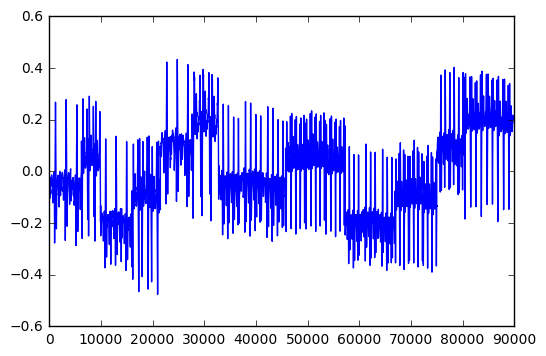

In [17]:
plt.plot(steering_train)

In [17]:
df = center2[center2['steering'] != 0]

In [29]:
#img = cv2.imread('IMG/' + basename(df['center'][2]))
#plt.imshow(img)
print(df['steering'].shape)

(1091,)


(array([  2.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          3.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   3.00000000e+00,   8.00000000e+00,
          1.50000000e+01,   2.20000000e+01,   1.60000000e+01,
          1.20000000e+01,   1.50000000e+01,   1.30000000e+01,
          3.40000000e+01,   4.80000000e+01,   1.27000000e+02,
          1.59000000e+02,   4.60000000e+01,   2.30000000e+01,
          1.90000000e+01,   4.10000000e+01,   7.20000000e+01,
          9.40000000e+01,   1.37000000e+02,   3.24100000e+03,
          1.80000000e+01,   1.30000000e+01,   6.00000000e+00,
          4.00000000e+00,   3.00000000e+00,   8.00000000e+00,
          1.70000000e+01,   2.30000000e+01,   1.40000000e+01,
          8.00000000e+00,   2.00000000e+00,   1.00000000e+00,
          4.00000000e+00,   4.00000000e+00,   6.00000000e+00,
          8.00000000e+00,   3.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
        

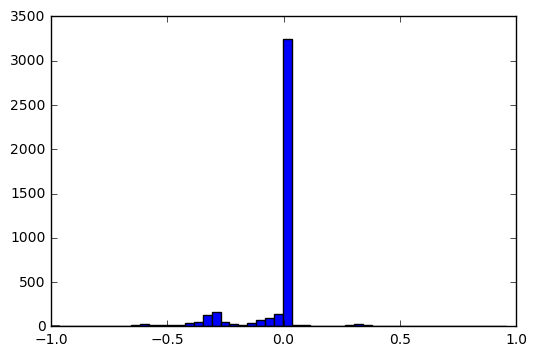

In [31]:
plt.hist(center2['steering'], bins=51)

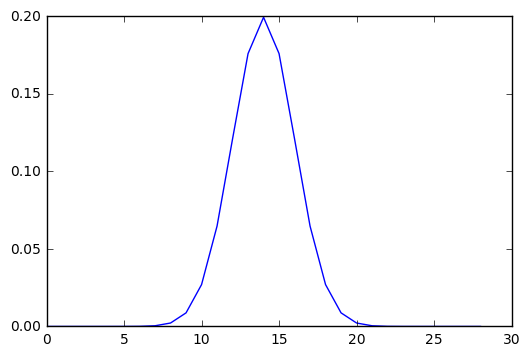

In [62]:
sigma = .2
mu = 0.
x = np.arange(-7*sigma, 7.1*sigma, sigma/2)
gaussian_window = (np.exp((-1.*x**2)/(2*sigma**2)))*(1./(np.sqrt(2*np.pi*sigma**2)))
gaussian_window = 1.*gaussian_window/np.sum(gaussian_window)
plt.plot(gaussian_window)
#plt.plot(center2['steering'], 'b', np.convolve(center2['steering'], gaussian_window, 'same'), 'r')
#plt.hist(np.convolve(center2['steering'], gaussian_window, 'same'), bins=51)

(array([   57.,    78.,   208.,   728.,   888.,  1244.,  2658.,  4285.,
         7756.,  5758.,  4804.,  5623.,  5778.,  8498.,  6754.,  5069.,
         4731.,  3768.,  5477.,  6058.,  3688.,  2139.,  1375.,   724.,
          986.,   542.,    83.]),
 array([-0.84584382, -0.78577152, -0.72569923, -0.66562693, -0.60555463,
        -0.54548233, -0.48541003, -0.42533774, -0.36526544, -0.30519314,
        -0.24512084, -0.18504855, -0.12497625, -0.06490395, -0.00483165,
         0.05524065,  0.11531294,  0.17538524,  0.23545754,  0.29552984,
         0.35560213,  0.41567443,  0.47574673,  0.53581903,  0.59589133,
         0.65596362,  0.71603592,  0.77610822]),
 <a list of 27 Patch objects>)

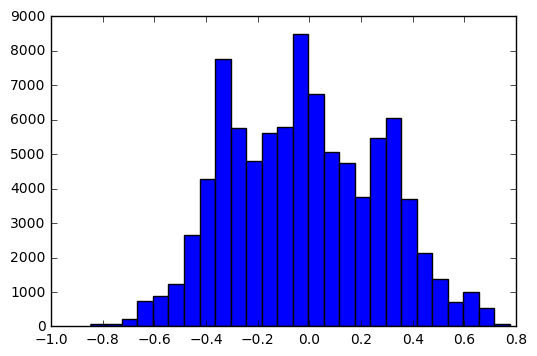

In [34]:
plt.hist(np.convolve(steering_train, 2.*gaussian_window, 'same'), bins=27)

In [83]:
steering_train_g = np.convolve(steering_train, 2.*gaussian_window, 'same')

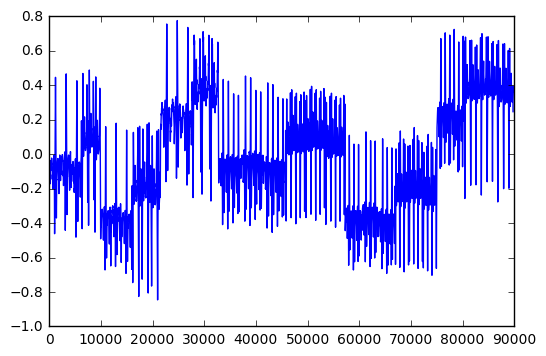

In [84]:
plt.plot(steering_train_g)

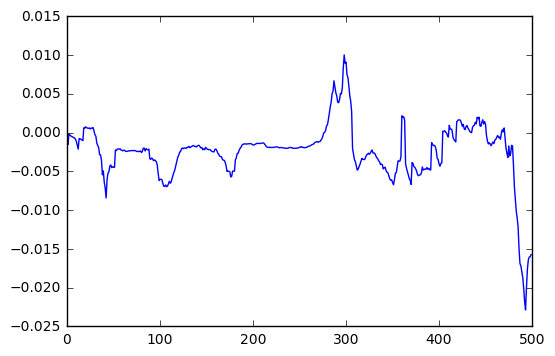

In [32]:
plt.plot(model.predict((img_z[0:500, :, :, :] - img_z[0:500, :, :, :].mean())/img_z[0:500, :, :, :].max()))

(array([ 7240.,     0.,     0.,     0.,     0.,  8486.,     0.,     0.,
            0.,  6425.]),
 array([-0.1 , -0.08, -0.06, -0.04, -0.02,  0.  ,  0.02,  0.04,  0.06,
         0.08,  0.1 ]),
 <a list of 10 Patch objects>)

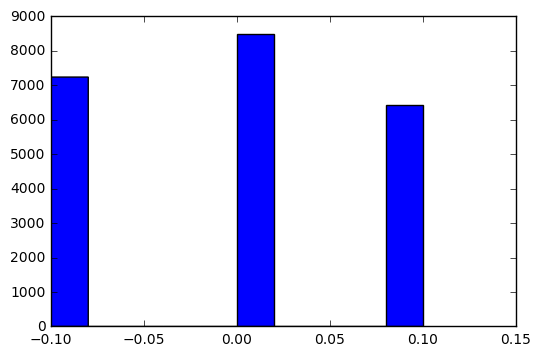

In [32]:
plt.hist(steering0_train)

15.9647636326


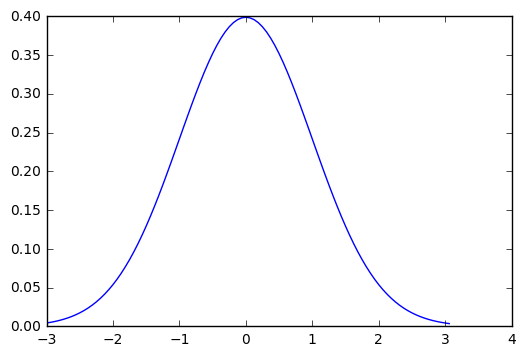

In [110]:
sigma = 1.
mu = 0.
x = np.arange(-3*sigma, 3.1*sigma, sigma/16)
gaussian_ = (np.exp((-1.*x**2)/(2*sigma**2)))*(1./(np.sqrt(2*np.pi*sigma**2)))
plt.plot(x, gaussian_)
print(np.sum(gaussian_))

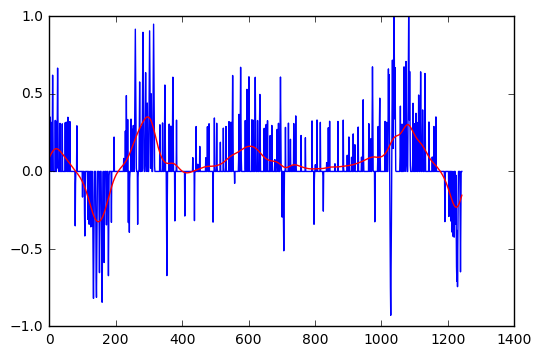

In [115]:
teste = np.convolve(center_rev['steering'], 1.5*gaussian_/np.sum(gaussian_), 'same')
plt.plot(center_rev['steering'], 'b', teste, 'r')

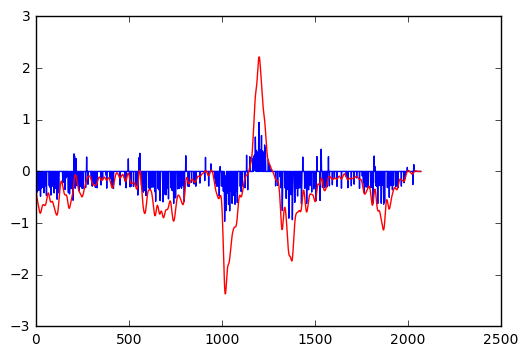

In [26]:
teste = np.convolve(center['steering'], gaussian_, 'same')
plt.plot(center['steering'], 'b', teste, 'r')

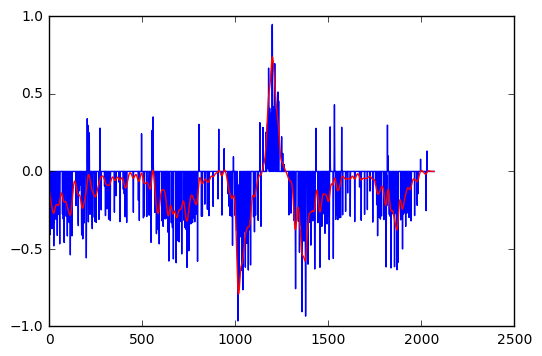

In [32]:
teste = np.convolve(center['steering'], gaussian_, 'same')
plt.plot(center['steering'], 'b', teste, 'r')

In [16]:
print(center_rev['steering'].shape)

(1243,)


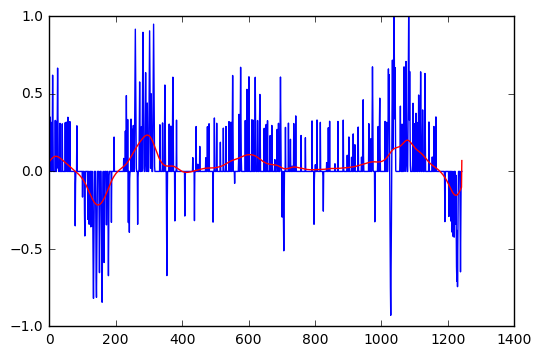

In [17]:
plt.plot(center_rev['steering'], 'b', steering_train[6208:7451], 'r')

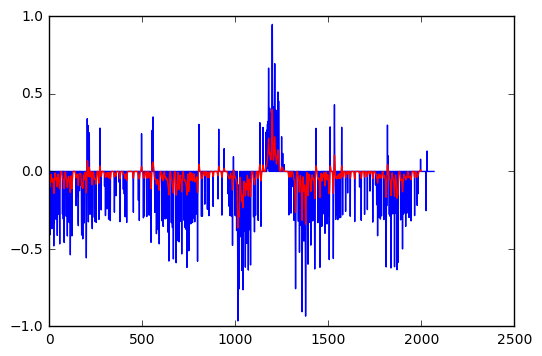

In [16]:
plt.plot(center['steering'], 'b', steering_train[0:2000], 'r')

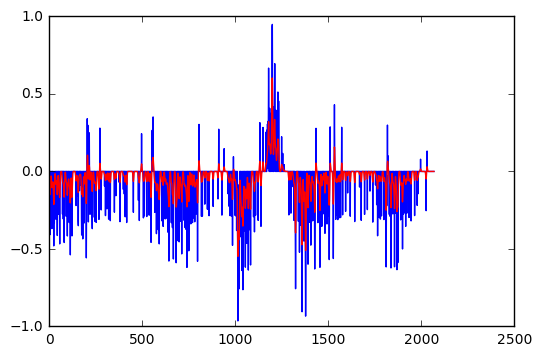

In [23]:
from scipy.ndimage.filters import gaussian_filter1d
plt.plot(center['steering'], 'b', gaussian_filter1d(center['steering'], 3), 'r')

In [23]:
print(np.sum(window)/np.sum(gaussian_))

2.34884438697


In [18]:
#from scipy.signal import gaussian
window = gaussian(30, std=5.)

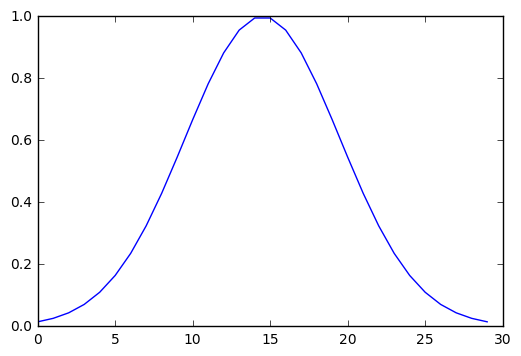

In [19]:
plt.plot(window)

In [100]:
print(np.sum(window))

12.5331344906


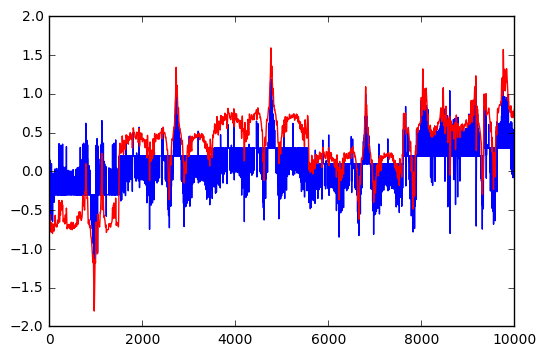

In [118]:
teste = np.convolve(steering_train, window, 'same')
plt.plot(steering_train[20000:30000], 'b', teste[20000:30000]/5., 'r')

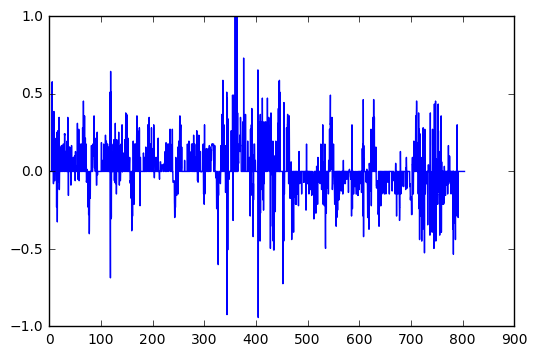

In [97]:
udacity_data = visualize_dataset('udacity_data/driving_log.csv')

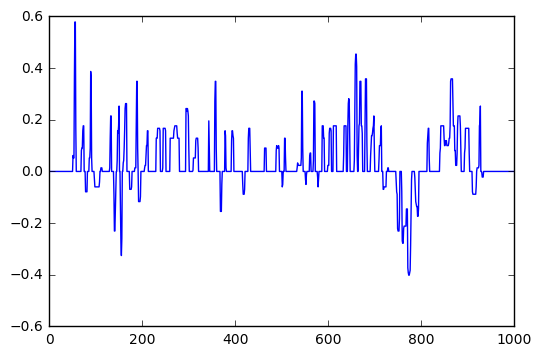

In [99]:
plt.plot(udacity_data['steering'][0:1000])

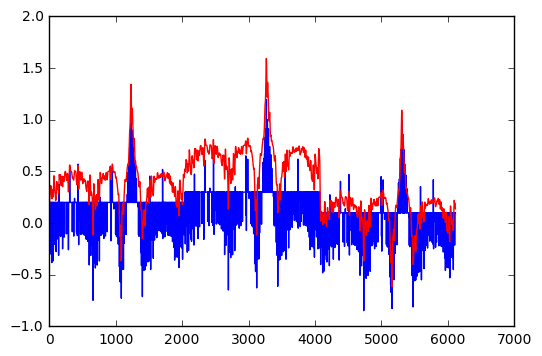

In [126]:
tL = add_bias(to_right['steering'], bias=0.2)
tL_conv = np.convolve(tL, window, 'same')
plt.plot(tL, 'b', tL_conv/5, 'r')

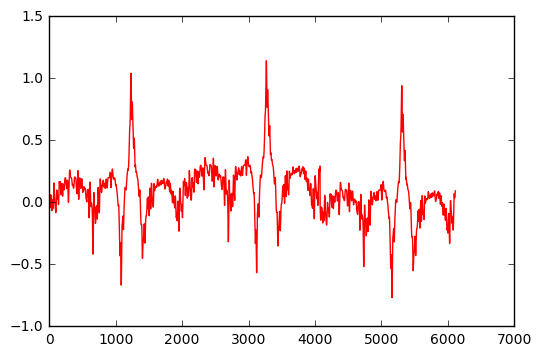

In [128]:
tL = add_bias(to_right['steering'], bias=0.2)
#tL_conv = np.convolve(tL, window, 'same')
plt.plot(tL, 'r')

In [15]:
import time
img = cv2.imread('IMG/' + basename(to_right['center'][100]))
start_time = time.time()
img_t = cv2.resize(img, (32, 32), interpolation=cv2.INTER_AREA)
img_t = img_t/255. - 0.5
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0005018711090087891 seconds ---


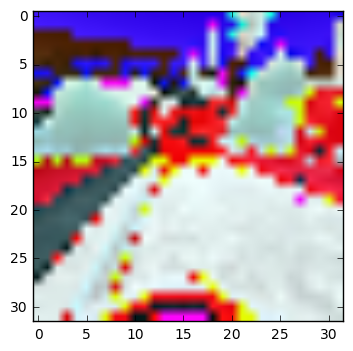

In [16]:
plt.imshow(img_t)

In [7]:
print(np.mean(img_train), np.std(img_train))

0.00871463352844 0.176037968621


In [10]:
import time
start_time = time.time()
model.predict(img_train[0:1, :, :, :])
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.9279794692993164 seconds ---


In [11]:
import time
start_time = time.time()
model.predict(img_train[0:1, :, :, :])
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.32877302169799805 seconds ---


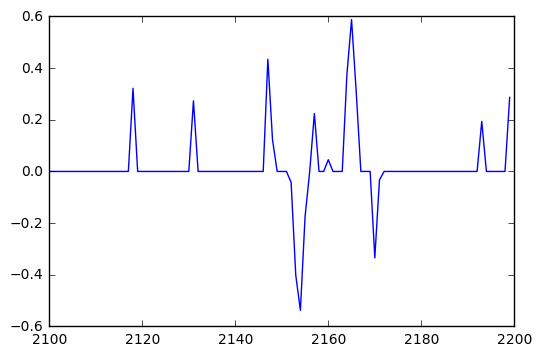

In [68]:
plt.plot(to_right_rev2['steering'][2100:2200])

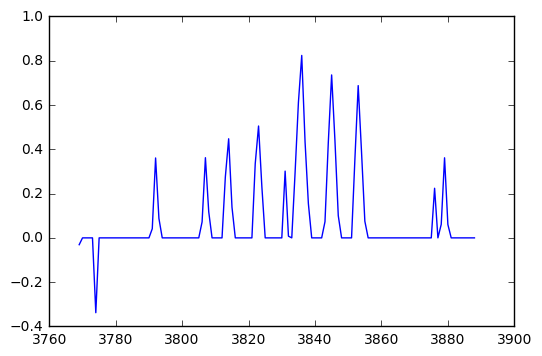

In [28]:
plt.plot(center_rev2['steering'][-120:])

In [6]:
np.append([[1, 2, 3]], [[4, 5, 6], [7, 8, 9]], axis=0)

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])